In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn import metrics
import shap
import lime
import lime.lime_tabular
import pickle
import warnings
warnings.filterwarnings('ignore')
shap.initjs()

In [2]:
data_raw = pd.read_stata('MIMIC-SAD_dta_files/MIMIC-IV.dta')
data = pd.read_stata('MIMIC-SAD_dta_files/MIMIC-IV.dta')
dummies = pd.get_dummies(data['race'])
data = data.drop('race',axis=1).join(dummies)
dummies = pd.get_dummies(data['first_careunit'])
data = data.drop('first_careunit',axis=1).join(dummies)

In [3]:
x=3
data.iloc[:,0+x*18:18+x*18]
data

stay_id   age      weight  gender  temperature  heart_rate  resp_rate  \
0      30000646  44.0   79.000000       0    37.000000       100.0       28.0   
1      30001446  56.0  119.300003       0    36.720001        82.0       22.0   
2      30002415  73.0   83.500000       1    36.439999        71.0       16.0   
3      30003226  67.0   93.449997       0    37.220001        89.0       17.0   
4      30004242  76.0   77.599998       1    36.720001        59.0       21.0   
...         ...   ...         ...     ...          ...         ...        ...   
14615  39993425  93.0   47.799999       1    35.830002       115.0       16.0   
14616  39993476  67.0   93.000000       0    36.439999        81.0       16.0   
14617  39993968  91.0   57.500000       1    35.830002        43.0       17.0   
14618  39996044  59.0   66.400002       0    36.389999       105.0       23.0   
14619  39999301  78.0  107.699997       0    36.610001        58.0       15.0   

        spo2    sbp   dbp  ...  OTHER  WHITE  unknown  CCU  CVICU  MICU  \
0       98.0  107.0  66.0  ...      0      0        0    1      0     0   
1       90.0   75.0  56.0  ...      0      1        0    0      0     1   
2      100.0  117.0  67.0  ...      0      1        0    0      1     0   
3       98.0  111.0  63.0  ...      0      0        0    0      0     0   
4       97.0  107.0  90.0  ...      0      0        0    0      0     0   
...      ...    ...   ...  ...    ...    ...      ...  ...    ...   ...   
14615   99.0   97.0  71.0  ...      0      1        0    0      0     1   
14616  100.0  112.0  60.0  ...      0      1        0    0      1     0   
14617  100.0   78.0  39.0  ...      0      1        0    1      0     0   
14618  100.0  107.0  63.0  ...      0      1        0    0      0     1   
14619   96.0  108.0  62.0  ...      0      0        0    0      1     0   

       MICU/SICU  NICU  SICU  TSICU  
0              0     0     0      0  
1              0     0     0      0  
2              0     0     0      0  
3              0     0     1      0  
4              0     0     0      1  
...          ...   ...   ...    ...  
14615          0     0     0      0  
14616          0     0     0      0  
14617          0     0     0      0  
14618          0     0     0      0  
14619          0     0     0      0  

[14620 rows x 61 columns]

In [4]:
data2 = data.drop(['deliriumtime', 'hosp_mort', 'icu28dmort', 'stay_id', 'icustay', 'hospstay', 'sepsistime'], axis=1)

<Axes: >

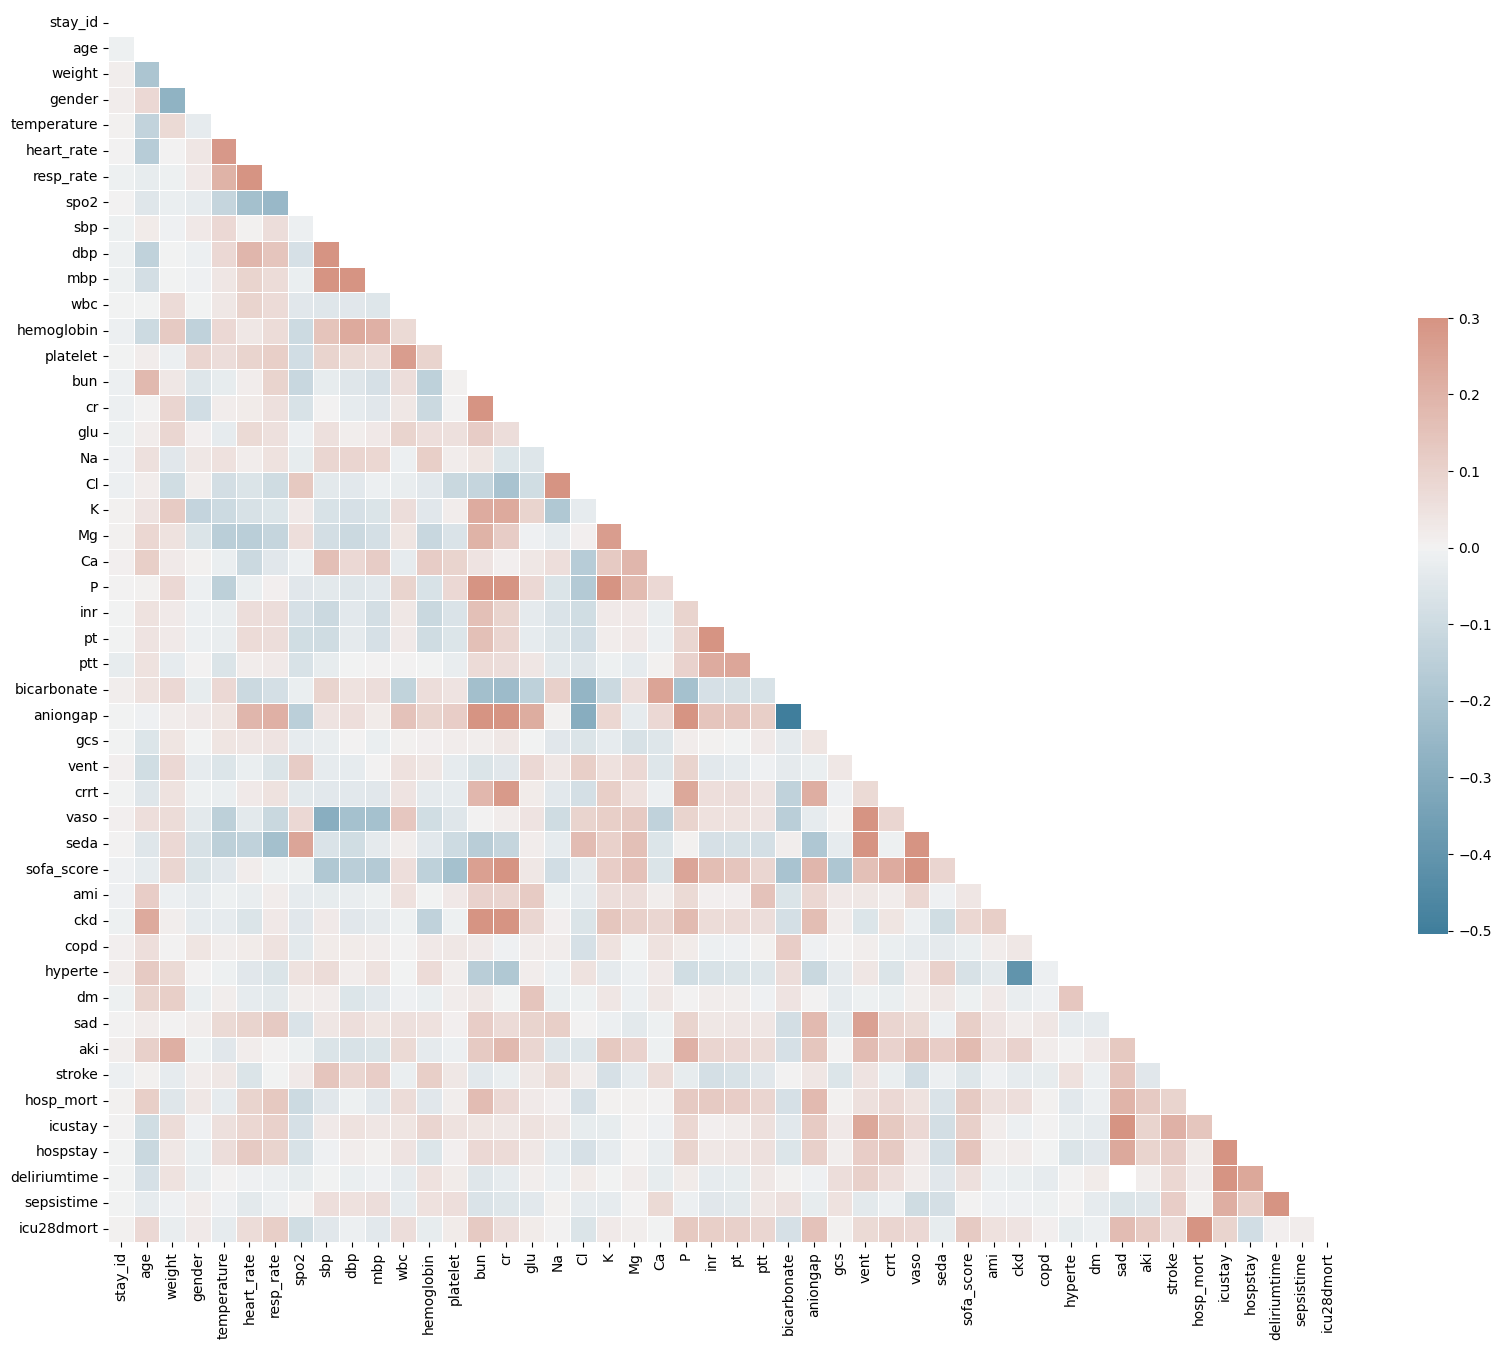

In [5]:


# Compute the correlation matrix
corr = data_raw.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [6]:
x=2
data2.iloc[:,0+x*18:18+x*18]
data2

age      weight  gender  temperature  heart_rate  resp_rate   spo2  \
0      44.0   79.000000       0    37.000000       100.0       28.0   98.0   
1      56.0  119.300003       0    36.720001        82.0       22.0   90.0   
2      73.0   83.500000       1    36.439999        71.0       16.0  100.0   
3      67.0   93.449997       0    37.220001        89.0       17.0   98.0   
4      76.0   77.599998       1    36.720001        59.0       21.0   97.0   
...     ...         ...     ...          ...         ...        ...    ...   
14615  93.0   47.799999       1    35.830002       115.0       16.0   99.0   
14616  67.0   93.000000       0    36.439999        81.0       16.0  100.0   
14617  91.0   57.500000       1    35.830002        43.0       17.0  100.0   
14618  59.0   66.400002       0    36.389999       105.0       23.0  100.0   
14619  78.0  107.699997       0    36.610001        58.0       15.0   96.0   

         sbp   dbp   mbp  ...  OTHER  WHITE  unknown  CCU  CVICU  MICU  \
0      107.0  66.0  75.0  ...      0      0        0    1      0     0   
1       75.0  56.0  61.0  ...      0      1        0    0      0     1   
2      117.0  67.0  87.0  ...      0      1        0    0      1     0   
3      111.0  63.0  71.0  ...      0      0        0    0      0     0   
4      107.0  90.0  94.0  ...      0      0        0    0      0     0   
...      ...   ...   ...  ...    ...    ...      ...  ...    ...   ...   
14615   97.0  71.0  80.0  ...      0      1        0    0      0     1   
14616  112.0  60.0  78.0  ...      0      1        0    0      1     0   
14617   78.0  39.0  49.0  ...      0      1        0    1      0     0   
14618  107.0  63.0  80.0  ...      0      1        0    0      0     1   
14619  108.0  62.0  73.0  ...      0      0        0    0      1     0   

       MICU/SICU  NICU  SICU  TSICU  
0              0     0     0      0  
1              0     0     0      0  
2              0     0     0      0  
3              0     0     1      0  
4              0     0     0      1  
...          ...   ...   ...    ...  
14615          0     0     0      0  
14616          0     0     0      0  
14617          0     0     0      0  
14618          0     0     0      0  
14619          0     0     0      0  

[14620 rows x 54 columns]

In [7]:
np.random.seed(123)
index = np.random.rand(len(data2)) < 0.7
train = data2[index]
test = data2[~index]

In [28]:
test.to_stata('test_set.dta')

In [27]:
train_raw = data_raw[index].to_stata('train_set_raw')

In [26]:
print(index)

[ True  True  True ...  True  True  True]


In [25]:
train.to_stata('train_set')

In [8]:
train_matrix = xgb.DMatrix(train.loc[:, ~train.columns.isin(["sad"])], label=train["sad"])
test_matrix = xgb.DMatrix(test.loc[:, ~test.columns.isin(["sad"])], label=test["sad"])

In [9]:
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 3,
    "eta": 0.1,
    "gamma": 0.5,
    "colsample_bytree": 1,
    "min_child_weight": 1,
    "subsample": 0.5,
    "seed": 123
}
watchlist = [(train_matrix, "train"), (test_matrix, "val")]
xgb_model = xgb.train(params=params, dtrain=train_matrix, num_boost_round=125, evals=watchlist,
                      early_stopping_rounds=10, verbose_eval=10)

[0]	train-logloss:0.63979	val-logloss:0.64264
[10]	train-logloss:0.56640	val-logloss:0.57160
[20]	train-logloss:0.54387	val-logloss:0.55215
[30]	train-logloss:0.53063	val-logloss:0.54359
[40]	train-logloss:0.52102	val-logloss:0.53830
[50]	train-logloss:0.51373	val-logloss:0.53539
[60]	train-logloss:0.50700	val-logloss:0.53184
[70]	train-logloss:0.50175	val-logloss:0.53095
[80]	train-logloss:0.49681	val-logloss:0.53020
[90]	train-logloss:0.49229	val-logloss:0.52977
[100]	train-logloss:0.48864	val-logloss:0.53065


In [10]:
print(type(xgb_model))

<class 'xgboost.core.Booster'>


In [11]:
pickle.dump(xgb_model, open("xgb.pkl", "wb"))

[[2329  721]
 [ 407  904]]


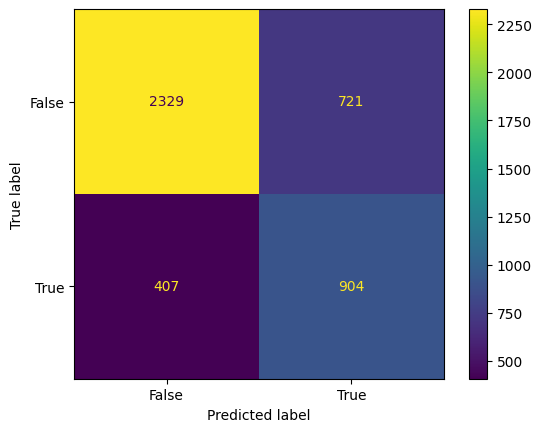

In [12]:
xgb_pred_prob = xgb_model.predict(test_matrix)
xgb_pred = np.where(xgb_pred_prob > 0.5, 1, 0)
xgb_pred_factor = pd.factorize(xgb_pred)[0]
test_sad_factor = pd.factorize(test["sad"])[0]

confusion_matrix = metrics.confusion_matrix(xgb_pred_factor, test_sad_factor)
print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 


In [13]:
xgb_pred_prob

array([0.18503565, 0.6261598 , 0.1572482 , ..., 0.7053726 , 0.32250598,
       0.18439463], dtype=float32)

In [14]:
test[:1]

age     weight  gender  temperature  heart_rate  resp_rate  spo2    sbp  \
4  76.0  77.599998       1    36.720001        59.0       21.0  97.0  107.0   

    dbp   mbp  ...  OTHER  WHITE  unknown  CCU  CVICU  MICU  MICU/SICU  NICU  \
4  90.0  94.0  ...      0      0        0    0      0     0          0     0   

   SICU  TSICU  
4     0      1  

[1 rows x 54 columns]

In [15]:
test.iloc[:,41]

4        0
6        0
11       0
15       0
21       0
        ..
14597    0
14601    0
14606    0
14609    0
14612    0
Name: AISAN, Length: 4361, dtype: uint8

In [16]:
xgb_model.predict(xgb.DMatrix(test.drop('sad',axis=1)[:1]))


array([0.18503565], dtype=float32)

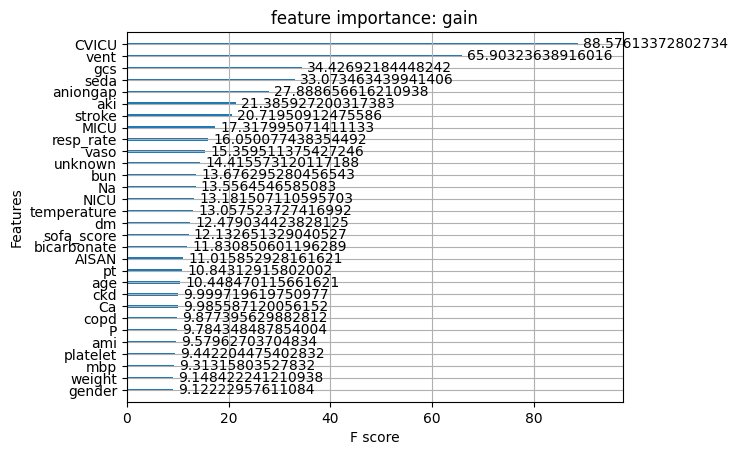

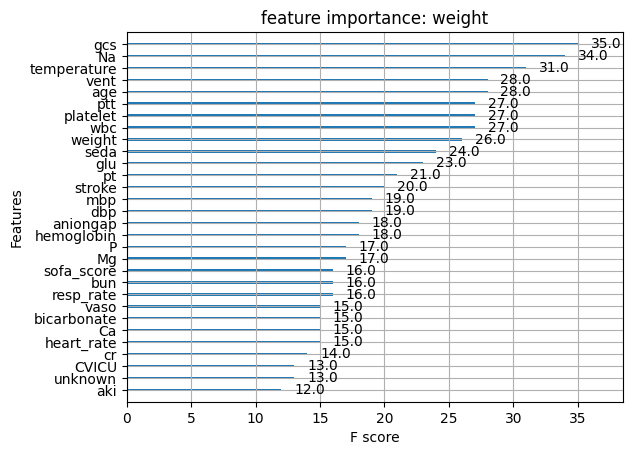

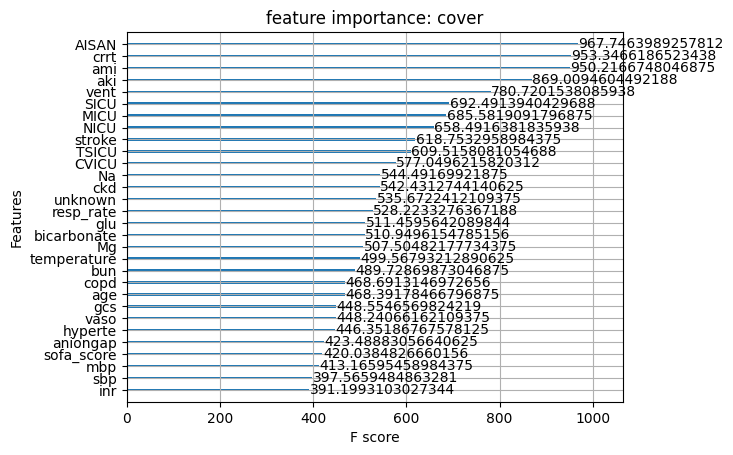

In [17]:
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=30)
plt.title('feature importance: gain')
plt.show()
xgb.plot_importance(xgb_model, max_num_features=30)
plt.title('feature importance: weight')
plt.show()
xgb.plot_importance(xgb_model, importance_type='cover', max_num_features=30)
plt.title('feature importance: cover')
plt.show()

In [18]:
data2.loc[:, ~data2.columns.isin(["sad"])]

age      weight  gender  temperature  heart_rate  resp_rate   spo2  \
0      44.0   79.000000       0    37.000000       100.0       28.0   98.0   
1      56.0  119.300003       0    36.720001        82.0       22.0   90.0   
2      73.0   83.500000       1    36.439999        71.0       16.0  100.0   
3      67.0   93.449997       0    37.220001        89.0       17.0   98.0   
4      76.0   77.599998       1    36.720001        59.0       21.0   97.0   
...     ...         ...     ...          ...         ...        ...    ...   
14615  93.0   47.799999       1    35.830002       115.0       16.0   99.0   
14616  67.0   93.000000       0    36.439999        81.0       16.0  100.0   
14617  91.0   57.500000       1    35.830002        43.0       17.0  100.0   
14618  59.0   66.400002       0    36.389999       105.0       23.0  100.0   
14619  78.0  107.699997       0    36.610001        58.0       15.0   96.0   

         sbp   dbp   mbp  ...  OTHER  WHITE  unknown  CCU  CVICU  MICU  \
0      107.0  66.0  75.0  ...      0      0        0    1      0     0   
1       75.0  56.0  61.0  ...      0      1        0    0      0     1   
2      117.0  67.0  87.0  ...      0      1        0    0      1     0   
3      111.0  63.0  71.0  ...      0      0        0    0      0     0   
4      107.0  90.0  94.0  ...      0      0        0    0      0     0   
...      ...   ...   ...  ...    ...    ...      ...  ...    ...   ...   
14615   97.0  71.0  80.0  ...      0      1        0    0      0     1   
14616  112.0  60.0  78.0  ...      0      1        0    0      1     0   
14617   78.0  39.0  49.0  ...      0      1        0    1      0     0   
14618  107.0  63.0  80.0  ...      0      1        0    0      0     1   
14619  108.0  62.0  73.0  ...      0      0        0    0      1     0   

       MICU/SICU  NICU  SICU  TSICU  
0              0     0     0      0  
1              0     0     0      0  
2              0     0     0      0  
3              0     0     1      0  
4              0     0     0      1  
...          ...   ...   ...    ...  
14615          0     0     0      0  
14616          0     0     0      0  
14617          0     0     0      0  
14618          0     0     0      0  
14619          0     0     0      0  

[14620 rows x 53 columns]

In [19]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(data2.loc[:, ~data2.columns.isin(["sad"])])

In [20]:
#dit kan in scherm individuele patient
shap.force_plot(explainer.expected_value, shap_values[0, :], data2.loc[:, ~data2.columns.isin(["sad"])].iloc[0, :])

In [21]:
# dit is niet zo nuttig maar wel gewoon heel vet
shap.force_plot(
    explainer.expected_value, shap_values[:1000, :], data2.loc[:, ~data2.columns.isin(["sad"])].iloc[:1000, :]
)

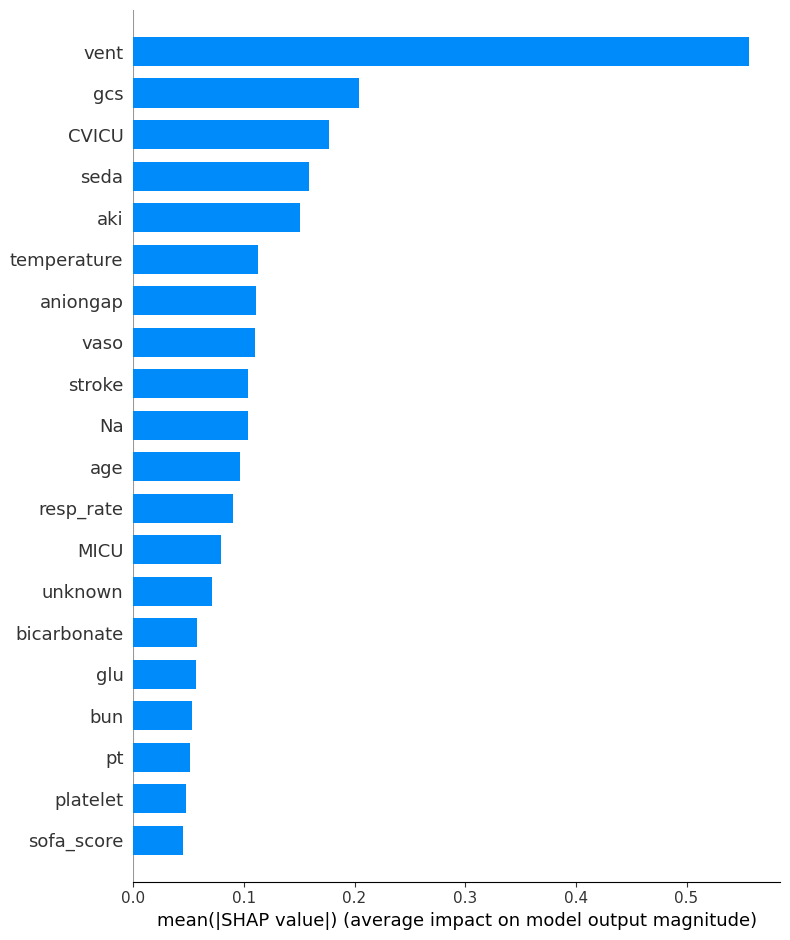

In [22]:
# dit kan handig zijn voor globale uitleg over model, even kijken of dit wenselijker is dan feature importance gain van XGB
shap.summary_plot(shap_values, data2.loc[:, ~data2.columns.isin(["sad"])], plot_type="bar")

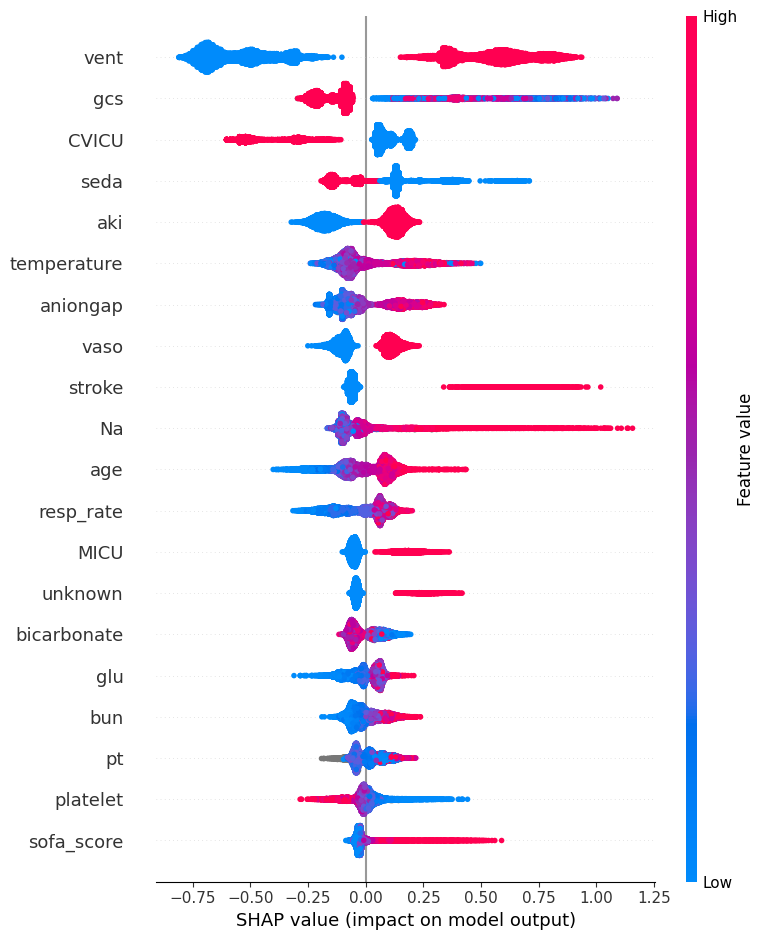

In [23]:
# wel mooi deze maar een beetje convoluted
shap.summary_plot(shap_values, data2.loc[:, ~data2.columns.isin(["sad"])])

## LIME

In [24]:
X = data2.loc[:, ~data2.columns.isin(["sad"])]
X_train = train.loc[:, ~train.columns.isin(["sad"])]
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, mode='classification')

InvalidIndexError: (slice(None, None, None), 0)

In [ ]:
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 3,
    "eta": 0.1,
    "gamma": 0.5,
    "colsample_bytree": 1,
    "min_child_weight": 1,
    "subsample": 0.5,
    "seed": 123
}
watchlist = [(train_matrix, "train"), (test_matrix, "val")]
xgb_model = xgb.train(params=params, dtrain=train_matrix, num_boost_round=125, evals=watchlist,
                      early_stopping_rounds=10, verbose_eval=10)